In [3]:
import torch
import torch.nn as nn
import time
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

class composite_score(nn.Module):
    def __init__(self, norm, nhead):
        super().__init__()
        if norm == True:
            self.norm = HeadValueNormalization(nhead)
        else:
            self.norm = nn.Identity()

    def forward(self, q, k, z=None):
        _, _, _, d = q.shape
        msd = math.sqrt(d)
        q = torch.sum(q, dim=-1, keepdim=True) / msd
        k = torch.sum(k, dim=-1, keepdim=True) / msd
        q_, k_ = torch.unsqueeze(q, 3), torch.unsqueeze(k, 2)
        qk = torch.cat([q_ + torch.zeros_like(k_), k_ + torch.zeros_like(q_)], dim=-1)
        print(qk.shape)
        if z != None:
            qk = qk + z
        return torch.max(qk, dim=-1)[0]
        # qk = F.softmax(qk, dim=-1) * qk
        # return torch.sum(qk, dim=-1)

In [ ]:
composite_score()(torch.randn(2, 8, 6, 16), torch.randn(2, 8, 9, 16))

In [1]:
import torch
import math

def score(q, k):
    _, _, _, d = q.shape
    q_, k_ = torch.unsqueeze(q, 3), torch.unsqueeze(k, 2)
    qk = torch.stack([q_ + torch.zeros_like(k_), k_ + torch.zeros_like(q_)], dim=-1)
    qk = (torch.max(qk, dim=-1)[0] - 0.5641895835) / 0.8256452711
    return torch.sum(qk, dim=-1) / math.sqrt(d)

In [34]:
import torch
import torch.nn as nn
from layer import RESC
import time
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

torch.set_num_threads(1)

RESC_layers = [RESC(256, 8, n_sampled_points, n_sampled_points, 0.1, False, 2048, 0.1, 'composite') for n_sampled_points in [16, 32, 64, 128, 256, 512]]
for i in range(len(RESC_layers)):
    RESC_layers[i] = RESC_layers[i].train()
    RESC_layers[i](torch.randn(2, 1024, 256))

TRAN_layer = nn.TransformerEncoderLayer(256, 8, 2048, 0.1, batch_first=True)
TRAN_layer(torch.randn(2, 1024, 256))

input = torch.randn(4, 1024, 256)

lst = []
for j in range(10):
    start_time = time.time()
    TRAN_layer(input)
    end_time = time.time()
    lst.append(end_time - start_time)
print(sum(lst) / len(lst))

for i in range(len(RESC_layers)):
    lst = []
    for j in range(10):
        start_time = time.time()
        RESC_layers[i](input)
        end_time = time.time()
        lst.append(end_time - start_time)
    print(sum(lst) / len(lst))


# layer1 = RESC(256, 8, 256, 256, 0.1, False, 2048, 0.1, 'composite')
# layer2 = nn.TransformerEncoderLayer(256, 8, 2048, 0.1, batch_first=True)

# layer1 = layer1.train()
# layer2 = layer2.train()

# input = torch.randn(1, 512, 256)
# start_time_l1 = time.time()
# layer1(input)
# end_time_l1 = time.time()

# start_time_l2 = time.time()
# layer2(input)
# end_time_l2 = time.time()

# time_speedup = []
# sampled_points = [1024]

# for ns in sampled_points:
#     input = torch.randn(64, ns, 256)
#     start_time_l1 = time.time()
#     layer1(input)
#     end_time_l1 = time.time()

#     start_time_l2 = time.time()
#     layer2(input)
#     end_time_l2 = time.time()

#     time_speedup.append((end_time_l2 - start_time_l2) / (end_time_l1 - start_time_l1))
#     print(ns, time_speedup[-1])

# # Create a DataFrame from the lists
# data = pd.DataFrame({'Sampled Objects': sampled_points, 'Time Speedup': time_speedup})

# # Set up the Seaborn style
# sns.set(style="whitegrid")

# # Create a Seaborn lineplot
# plt.figure(figsize=(10, 6))
# plot = sns.lineplot(x='Sampled Objects', y='Time Speedup', data=data, marker='o', color='blue', label='Sampling-based Transformer Layer')

# # Set plot labels and title
# plt.xlabel('Number of Sampled Objects')
# plt.ylabel('Time Speedup')
# plt.title('Time Speedup vs Number of Sampled Objects')

# # Add a horizontal line at y=1.0
# plt.axhline(y=1.0, color='red', linestyle='--', label='Vanila Transformer Layer')

# plt.legend()
# # Show the plot
# plt.savefig('seaborn_plot.pdf', dpi=300)
# plt.show()


9.842049264907837
7.442766785621643
7.30245258808136
7.294587016105652


KeyboardInterrupt: 

In [22]:
import numpy as np

def rotate_point_cloud(batch_data):
    """ Randomly rotate the point clouds to augument the dataset
        rotation is per shape based along up direction
        Input:
          Nx3 array, original batch of point clouds
        Return:
          Nx3 array, rotated batch of point clouds
    """
    batch_data = np.expand_dims(batch_data, axis=0)
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        angles = np.random.uniform(size=3) * 2 * np.pi
        print(angles)
        Rx = np.array([[1,0,0],
                    [0,np.cos(angles[0]),-np.sin(angles[0])],
                    [0,np.sin(angles[0]),np.cos(angles[0])]])
        Ry = np.array([[np.cos(angles[1]),0,np.sin(angles[1])],
                    [0,1,0],
                    [-np.sin(angles[1]),0,np.cos(angles[1])]])
        Rz = np.array([[np.cos(angles[2]),-np.sin(angles[2]),0],
                    [np.sin(angles[2]),np.cos(angles[2]),0],
                    [0,0,1]])
        R = np.dot(Rz, np.dot(Ry,Rx))

        rotated_data[k, ...] = np.dot(batch_data[k, ...], R)

    rotated_data = np.squeeze(rotated_data, axis=0)
    return rotated_data

[3.07549734 0.18183897 0.88366999]


array([[ 2.4974984e-01, -4.8405924e-01, -4.4785723e-01],
       [-6.3765335e-01, -9.6509874e-02,  4.5332730e-01],
       [-1.1855007e+00, -1.9034822e-01,  1.2294234e+00],
       [ 5.1123571e-01,  1.0902833e+00, -5.9210432e-01],
       [-1.2456214e+00,  3.0464321e-01,  7.3061049e-01],
       [ 1.1069599e+00, -1.0243858e+00,  1.3311896e+00],
       [ 1.7666999e-01,  4.2745379e-01, -1.0160563e-01],
       [-1.0762084e+00, -3.4184524e-01, -3.4119550e-02],
       [ 8.9682832e-02,  1.1980788e+00, -2.0523348e-01],
       [ 6.1160189e-01,  1.0690522e+00, -2.1409240e+00],
       [ 6.1583579e-01,  5.7182819e-01,  4.4150177e-02],
       [ 3.1024616e-02,  2.1540347e-01, -1.6171321e+00],
       [-5.8303732e-01, -7.9988146e-01, -2.7364045e-01],
       [ 1.5979688e-01, -1.3484293e+00, -4.0167525e-02],
       [-1.3376422e+00, -1.6908165e+00,  1.2543386e+00],
       [-7.5391553e-02,  2.7924359e-01,  1.0396241e+00],
       [-1.2561785e+00,  1.4272636e-01, -1.6593282e-01],
       [-1.2265134e+00, -7.3598

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint_sequential
import pytorch_warmup as warmup
from pytorch_lamb import Lamb, log_lamb_rs
import numpy as np
import random
import time
from copy import deepcopy
from tqdm import tqdm
from multimethod import multimethod
import argparse
import logging
from model import parse_point_architecture
from data.dataset import ModelNetDataLoader, PartNormalDataset
import warnings
warnings.filterwarnings('ignore')

# torch.set_num_threads(4)
torch.autograd.set_detect_anomaly(True)

In [52]:
model = parse_point_architecture('PCLL,256@RSTL,256,8,256,256,0.1,False,1024,0.1,composite,False,LayerNorm@RSTL,256,8,256,256,0.1,False,1024,0.1,composite,False,LayerNorm@RSTL,256,8,256,256,0.1,False,1024,0.1,composite,False,LayerNorm@RSTL,256,8,256,256,0.1,False,1024,0.1,composite,False,LayerNorm@RSTL,256,8,256,256,0.1,False,1024,0.1,composite,False,LayerNorm@RSTL,256,8,256,256,0.1,False,1024,0.1,composite,False,LayerNorm@RSTL,256,8,256,256,0.1,False,1024,0.1,composite,False,LayerNorm@RSTL,256,8,256,256,0.1,False,1024,0.1,composite,False,LayerNorm@CLFH,40,256,512,512,0.1', is_normal=True, is_rotation=True)

In [53]:
model(torch.randn(64, 1024, 6))

tensor([[ 0.5763,  0.2427,  0.2360,  ..., -0.4154, -0.0132, -0.4449],
        [ 0.6619,  0.1028,  0.2511,  ..., -0.3328, -0.1397, -0.4082],
        [ 0.5507,  0.1527,  0.2181,  ..., -0.3362, -0.2594, -0.4676],
        ...,
        [ 0.4791,  0.1353,  0.2853,  ..., -0.4209, -0.1650, -0.2766],
        [ 0.5971,  0.1324,  0.1782,  ..., -0.3636, -0.2724, -0.3713],
        [ 0.4522, -0.0012,  0.2049,  ..., -0.3426, -0.2628, -0.3258]],
       grad_fn=<AddmmBackward0>)

In [54]:
x = torch.load('./checkpoints/modelnet_submission_so3/seed_18/model_best.pth')

In [55]:
model.load_state_dict(x['model_state_dict'])

<All keys matched successfully>

In [2]:
root = './datasets'
data_path = os.path.join(root, "modelnet40_normal_resampled")

In [3]:
uniform = True
transform = False
use_normal = True
num_points = 1024
is_rotation = True
num_classes = 40
batch_size = 4

In [4]:
train_dataset = PartNormalDataset(root = './datasets/shapenetcore_partanno_segmentation_benchmark_v0_normal',
                                    npoints=2500, 
                                    split='train', 
                                    class_choice=None, 
                                    normal_channel=use_normal)
# trainDataLoader = torch.utils.data.DataLoader(train_dataset, 
#                                                 batch_size=batch_size, 
#                                                 shuffle=True, 
#                                                 num_workers=8, 
#                                                 drop_last=True)

# trainDataLoader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
# testDataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)


In [5]:
def augment(point_cloud):
  """
  Augments a point cloud with random rotation, translation, and scaling.

  Args:
    point_cloud: A numpy array of shape (n_points, 3) or (n_points, 4) representing the point cloud.

  Returns:
    A numpy array of the same shape as the input point cloud, with the augmented points.
  """

  # Get the number of points and dimensions
  n_points, dim = point_cloud.shape

  # Generate random rotation angle around the Z-axis
  angle = np.random.rand() * 2 * np.pi

  # Construct rotation matrix
  cos = np.cos(angle)
  sin = np.sin(angle)
  rotation = np.array([[cos, -sin, 0],
                       [sin, cos, 0],
                       [0, 0, 1]])

  # Apply rotation to the point cloud
  point_cloud[:, :3] = np.dot(rotation, point_cloud[:, :3].T).T

  point_cloud[:, :3] = point_cloud[:, :3] - np.mean(point_cloud, axis=0)

  # Randomly translate the point cloud
  translation = np.random.rand(3) - 0.5
  point_cloud[:, :3] += translation

#   # Randomly scale the point cloud
#   scale = np.random.rand(3) * 0.5 + 0.75
#   point_cloud[:, :3] *= scale

  return point_cloud

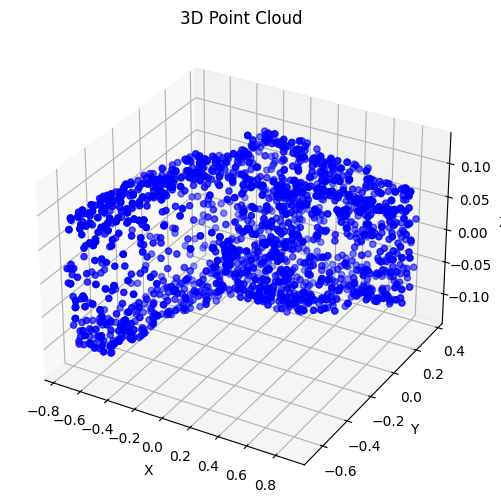

In [19]:
import matplotlib.pyplot as plt

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
data = train_dataset[8000][0][:,:3]
ax.scatter(data[:,0], data[:,1], data[:,2], c='b', marker='o')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Point Cloud')

# Show the plot
plt.show()

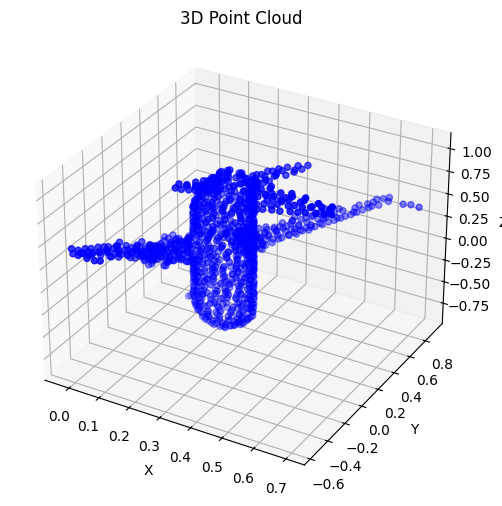

In [67]:
# Plot the data points
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

data = augment(test_dataset[3][0][:,:3])
ax.scatter(data[:,0], data[:,1], data[:,2], c='b', marker='o')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Point Cloud')

# Show the plot
plt.show()

In [61]:
model = model.to('cuda')

In [62]:
test_instance_accs = []
test_class_accs = []
for i in range(30):
    with torch.no_grad():
        test_mean_correct = []
        model = model.eval()
        test_class_acc = np.zeros((num_classes, 3))
        loop = tqdm(testDataLoader)
        for points, target in loop:
            points, target = points.cuda(), target.cuda()
            points = points.to(torch.float32)
            pred = model(points)
            pred_choice = pred.data.max(1)[1]
            for cat in np.unique(target.cpu()):
                classacc = pred_choice[target == cat].eq(target[target == cat].long().data).cpu().sum()
                test_class_acc[cat, 0] += classacc.item() / float(points[target == cat].size()[0])
                test_class_acc[cat, 1] += 1
            correct = pred_choice.eq(target.long().data).cpu().sum()
            test_mean_correct.append(correct.item() / float(points.size()[0]))
        test_class_acc[:, 2] =  test_class_acc[:, 0] / test_class_acc[:, 1]
        test_class_acc = np.mean(test_class_acc[:, 2])
        test_instance_acc = np.mean(test_mean_correct)
    test_instance_accs.append(test_instance_acc)
    test_class_accs.append(test_class_acc)
    print(sum(test_instance_accs) / len(test_instance_accs), sum(test_class_accs) / len(test_class_accs))

100%|██████████| 617/617 [01:05<00:00,  9.48it/s]


0.8788492706645057 0.8419018065268066


100%|██████████| 617/617 [01:04<00:00,  9.50it/s]


0.8780388978930308 0.8387689393939394


100%|██████████| 617/617 [01:04<00:00,  9.60it/s]


0.8784440842787683 0.838441822066822


100%|██████████| 617/617 [01:04<00:00,  9.54it/s]


0.8787479740680714 0.8375171182983683


100%|██████████| 617/617 [01:04<00:00,  9.51it/s]


0.8788492706645057 0.836828846153846


100%|██████████| 617/617 [01:04<00:00,  9.49it/s]


0.8789168017287953 0.8375005827505827


100%|██████████| 617/617 [00:56<00:00, 10.86it/s]


0.8790808057420699 0.8378203879453878


100%|██████████| 617/617 [00:58<00:00, 10.53it/s]


0.8786973257698542 0.8372997887529137


100%|██████████| 617/617 [01:04<00:00,  9.58it/s]


0.8788492706645057 0.8375427674177673


100%|██████████| 617/617 [01:04<00:00,  9.54it/s]


0.8785656401944895 0.837445134032634


100%|██████████| 617/617 [01:04<00:00,  9.57it/s]


0.8787387652865774 0.8377054725577452


100%|██████████| 617/617 [01:04<00:00,  9.54it/s]


0.8784103187466235 0.8371589695027194


100%|██████████| 617/617 [01:05<00:00,  9.46it/s]


0.8781012342600673 0.8368074905863365


100%|██████████| 617/617 [01:05<00:00,  9.47it/s]


0.878270432970595 0.8368229686979686


100%|██████████| 617/617 [01:04<00:00,  9.58it/s]


0.8783630470016207 0.836814355089355


100%|██████████| 617/617 [01:05<00:00,  9.43it/s]


0.8783174635332253 0.8368196204836829


100%|██████████| 617/617 [01:04<00:00,  9.54it/s]


0.8781342358661455 0.8369505518990812


100%|██████████| 617/617 [01:04<00:00,  9.52it/s]


0.8779038357644516 0.8368383029008029


100%|██████████| 617/617 [01:04<00:00,  9.53it/s]


0.8778682930990361 0.8369643755367439


100%|██████████| 617/617 [01:04<00:00,  9.57it/s]


0.877856564019449 0.8369140151515151


100%|██████████| 617/617 [01:04<00:00,  9.54it/s]


0.8778266574052636 0.8369594294594294


100%|██████████| 617/617 [01:05<00:00,  9.49it/s]


0.8777073817592456 0.8369926361517269


100%|██████████| 617/617 [01:05<00:00,  9.46it/s]


0.8778098795010921 0.8370389429411168


100%|██████████| 617/617 [01:04<00:00,  9.58it/s]


0.8779544840626686 0.8371401757964257


100%|██████████| 617/617 [01:04<00:00,  9.51it/s]


0.8780064829821717 0.8370854079254079


100%|██████████| 617/617 [01:04<00:00,  9.54it/s]


0.8780233138012716 0.8370967029765105


100%|██████████| 617/617 [01:05<00:00,  9.44it/s]


0.8782039738279608 0.8373729819563152


100%|██████████| 617/617 [01:05<00:00,  9.43it/s]


0.8781546654318129 0.8372682733932733


100%|██████████| 617/617 [01:05<00:00,  9.44it/s]


0.878080813726038 0.8370577626396591


100%|██████████| 617/617 [01:05<00:00,  9.48it/s]

0.8780794165316045 0.8370243492618492


In [65]:
ins_accs = np.array(test_instance_accs)

In [68]:
(ins_accs * 100).mean()

87.80794165316044

In [69]:
(ins_accs * 100).std()

0.21803646288585002